In [1]:
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

import matplotlib.pyplot as plt
import seaborn as sns

import joblib

import warnings
warnings.filterwarnings("ignore")

In [2]:

COLUMN_RENAME_MAP = {
    "TARİX": "timestamp",
    "XÜSUSİ ÇƏKİ\n(kq/m3)": "density_kg_m3",
    "TƏZYİQLƏR\nFƏRQİ (kPa)": "pressure_diff_kpa",
    "TƏZYİQ (kPa)": "pressure_kpa",
    "TEMPERATUR\n(C)": "temperature_c",
    "SAATLIQ\nSƏRF(min m3)": "hourly_flow_m3",
    "SƏRF (min m3)": "total_flow_m3",
}


def load_and_tag_csv(file_path: Path) -> pd.DataFrame:
    df = pd.read_csv(file_path)

    # Rename columns BEFORE concat
    df = df.rename(columns=COLUMN_RENAME_MAP)

    # Add location column
    df = df.copy()
    df["location"] = file_path.stem

    print(f"Loaded {file_path.name}: {len(df):,} rows")

    return df


def combine_location_files(file_paths: list[Path]) -> pd.DataFrame:
    dataframes = []
    total_expected_rows = 0

    for path in file_paths:
        df = load_and_tag_csv(path)
        dataframes.append(df)
        total_expected_rows += len(df)

    combined_df = pd.concat(
        dataframes,
        axis=0,
        ignore_index=True
    )

    print("-" * 50)
    print(f"Expected total rows : {total_expected_rows:,}")
    print(f"Combined DF rows   : {len(combined_df):,}")
    print(
        "Row loss detected  :",
        "YES" if total_expected_rows != len(combined_df) else "NO"
    )

    # Validation
    required_columns = set(COLUMN_RENAME_MAP.values()) | {"location"}
    missing = required_columns - set(combined_df.columns)

    if missing:
        raise RuntimeError(f"Missing expected columns: {missing}")

    return combined_df


if __name__ == "__main__":
    files = [
        Path("Mardakan.csv"),
        Path("Sumqayit.csv"),
        Path("Turkan.csv"),
    ]

    df = combine_location_files(files)

    print("-" * 50)
    print("Final columns:")
    print(df.columns.tolist())
    print("Unique locations:", df["location"].unique())

    # Optional save
    # df.to_csv("../data/combined_locations_clean.csv", index=False)

Loaded Mardakan.csv: 57,978 rows
Loaded Sumqayit.csv: 58,011 rows
Loaded Turkan.csv: 57,978 rows
--------------------------------------------------
Expected total rows : 173,967
Combined DF rows   : 173,967
Row loss detected  : NO
--------------------------------------------------
Final columns:
['timestamp', 'density_kg_m3', 'pressure_diff_kpa', 'pressure_kpa', 'temperature_c', 'hourly_flow_m3', 'total_flow_m3', 'location']
Unique locations: ['Mardakan' 'Sumqayit' 'Turkan']


In [3]:
numerical_cols = [
    "density_kg_m3",
    "pressure_diff_kpa",
    "pressure_kpa",
    "temperature_c",
    "hourly_flow_m3",
    "total_flow_m3",
]

df_features = df[numerical_cols].copy()

# Initialize StandardScaler
scaler = StandardScaler()

# Apply StandardScaler to the features and create a new DataFrame
df_scaled = pd.DataFrame(scaler.fit_transform(df_features), columns=df_features.columns)

print("Original features DataFrame head:")
print(df_features.head())
print("\nScaled features DataFrame head:")
print(df_scaled.head())
print(f"Shape of scaled DataFrame: {df_scaled.shape}")

Original features DataFrame head:
   density_kg_m3  pressure_diff_kpa  pressure_kpa  temperature_c  \
0        0.73703             6.1342       593.740         10.513   
1        0.73703             5.8290       606.206         10.330   
2        0.73703             5.9273       581.200          9.987   
3        0.73703             6.0022       561.711         10.138   
4        0.73703             5.6887       586.612         10.315   

   hourly_flow_m3  total_flow_m3  
0           4.494        107.860  
1           4.430        106.316  
2           4.374        104.987  
3           4.325        103.795  
4           4.304        103.287  

Scaled features DataFrame head:
   density_kg_m3  pressure_diff_kpa  pressure_kpa  temperature_c  \
0      -0.166476          -0.383036      1.128285      -0.334595   
1      -0.166476          -0.421043      1.258410      -0.345130   
2      -0.166476          -0.408802      0.997387      -0.364878   
3      -0.166476          -0.399474      0

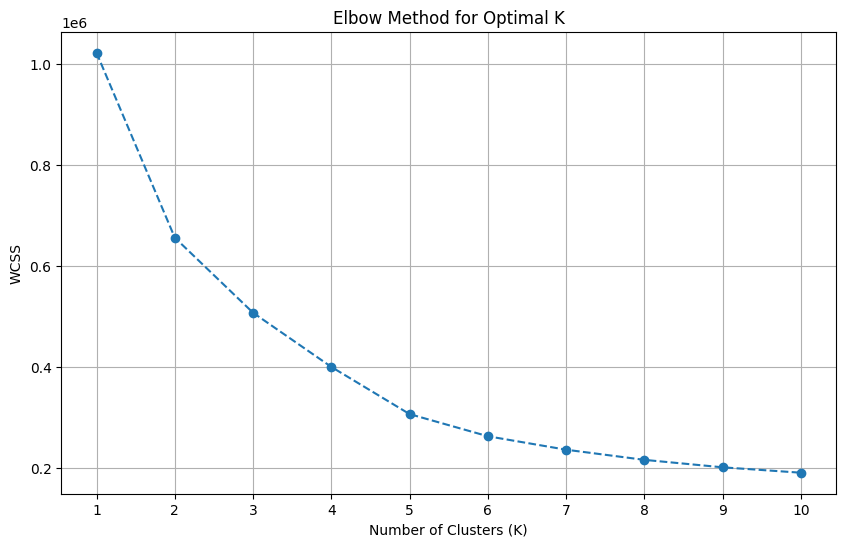

WCSS values for K from 1 to 10:
K = 1: WCSS = 1021734.00
K = 2: WCSS = 655633.38
K = 3: WCSS = 506999.46
K = 4: WCSS = 399727.65
K = 5: WCSS = 306325.04
K = 6: WCSS = 262480.98
K = 7: WCSS = 235839.67
K = 8: WCSS = 215739.30
K = 9: WCSS = 200988.95
K = 10: WCSS = 190302.55


In [5]:
from sklearn.cluster import KMeans

# Handle NaN values by filling them with 0 (or another appropriate strategy)
df_scaled = df_scaled.fillna(0)

# Determine the optimal number of clusters (K) using the Elbow method
wcss = [] # Within-cluster sum of squares
max_k = 10

for i in range(1, max_k + 1):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Elbow method graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_k + 1), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.xticks(range(1, max_k + 1))
plt.grid(True)
plt.show()

print("WCSS values for K from 1 to 10:")
for k_val, inertia_val in enumerate(wcss, 1):
    print(f"K = {k_val}: WCSS = {inertia_val:.2f}")

In [6]:
optimal_k = 3

# Apply K-means clustering with the optimal K
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(df_scaled)

print(f"K-means clustering applied with K = {optimal_k}")
print("Cluster distribution:")
print(df['cluster'].value_counts())

# Get the cluster centers
cluster_centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=numerical_cols)
print("\nCluster Centers (original scale):")
print(cluster_centers)

K-means clustering applied with K = 3
Cluster distribution:
cluster
2    85086
0    64123
1    24758
Name: count, dtype: int64

Cluster Centers (original scale):
   density_kg_m3  pressure_diff_kpa  pressure_kpa  temperature_c  \
0       0.736423          11.501070    571.463787      11.402099   
1       0.725312          17.206335    482.300943       3.289168   
2       0.745671           5.150573    421.822957      23.839242   

   hourly_flow_m3  total_flow_m3  
0        5.005957     120.142969  
1       33.793916     811.054027  
2        3.136915      75.285975  


In [7]:
from sklearn.metrics import pairwise_distances_argmin_min

# Calculate the distance of each point to its assigned centroid
distances = kmeans.transform(df_scaled)

# Get the distance to the assigned cluster centroid for each data point
df['distance'] = [distances[i, cluster_id] for i, cluster_id in enumerate(df['cluster'])]

print("Distance of each data point to its assigned cluster centroid calculated.")
print(df[['cluster', 'distance']].head())

Distance of each data point to its assigned cluster centroid calculated.
   cluster  distance
0        0  0.713661
1        0  0.800797
2        0  0.711904
3        0  0.702594
4        0  0.749895


In [8]:
isolation_forest = IsolationForest(contamination=0.01, random_state=42)
isolation_forest.fit(df[['distance']])

# Predict anomalies (where -1 indicates an outlier)
anomaly_predictions = isolation_forest.predict(df[['distance']])

# Get the anomaly scores (lower is more anomalous)
anomaly_scores = isolation_forest.decision_function(df[['distance']])

# The threshold is often taken as the maximum score for non-outliers
anomaly_threshold = anomaly_scores[anomaly_predictions == 1].min()

# Apply anomaly flag
df['is_anomaly'] = df['distance'] > -anomaly_threshold

print(f"Anomaly detection threshold based on IsolationForest: {-anomaly_threshold:.4f}")
print("Number of anomalies detected:", df['is_anomaly'].sum())
print(df[['cluster', 'distance', 'is_anomaly']].head())

Anomaly detection threshold based on IsolationForest: -0.0002
Number of anomalies detected: 173967
   cluster  distance  is_anomaly
0        0  0.713661        True
1        0  0.800797        True
2        0  0.711904        True
3        0  0.702594        True
4        0  0.749895        True


In [9]:
import numpy as np

# Set a percentile for anomaly detection (e.g., top 1% most distant points)
# This assumes that a small percentage of data points are true anomalies
anomaly_percentile = 0.99

# Calculate the anomaly threshold based on the percentile of distances
anomaly_threshold = df['distance'].quantile(anomaly_percentile)

# Flag points as anomalies if their distance is above the threshold
df['is_anomaly'] = df['distance'] > anomaly_threshold

print(f"Anomaly detection threshold (distance > {anomaly_threshold:.4f}) set at the {anomaly_percentile*100:.0f}th percentile of distances.")
print("Number of anomalies detected:", df['is_anomaly'].sum())
print("Percentage of anomalies detected:", np.round((df['is_anomaly'].sum() / len(df)) * 100, 2), "%")
print(df[['cluster', 'distance', 'is_anomaly']].head())

Anomaly detection threshold (distance > 3.4163) set at the 99th percentile of distances.
Number of anomalies detected: 1740
Percentage of anomalies detected: 1.0 %
   cluster  distance  is_anomaly
0        0  0.713661       False
1        0  0.800797       False
2        0  0.711904       False
3        0  0.702594       False
4        0  0.749895       False


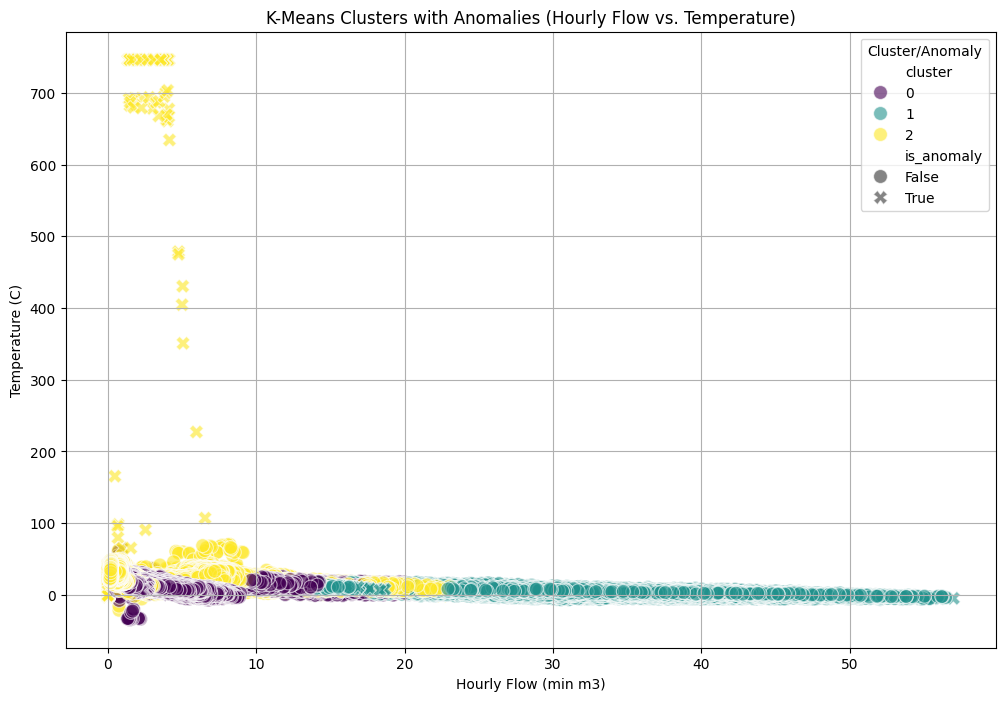

Visualization of K-Means clusters and anomalies generated.


In [10]:
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='hourly_flow_m3',
    y='temperature_c',
    hue='cluster',
    style='is_anomaly',
    data=df,
    palette='viridis',
    s=100,
    alpha=0.6,
    hue_order=sorted(df['cluster'].unique()),
    markers={False: 'o', True: 'X'}
)

plt.title('K-Means Clusters with Anomalies (Hourly Flow vs. Temperature)')
plt.xlabel('Hourly Flow (min m3)')
plt.ylabel('Temperature (C)')
plt.legend(title='Cluster/Anomaly')
plt.grid(True)
plt.show()

print("Visualization of K-Means clusters and anomalies generated.")